# Titanic - Machine Learning from Disaster

Датасет взят из https://www.kaggle.com/c/titanic/data


Результат сабмита = 0.78229

In [1]:
# импортируем библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# загружаем данные
train = pd.read_csv('../data/titanic/train.csv')

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Survived - таргетная переменная. Бинарный признак,выжил ли пассажир.

# Подготовка данных и EDA

In [3]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Посмотрим базовые предположения о данных

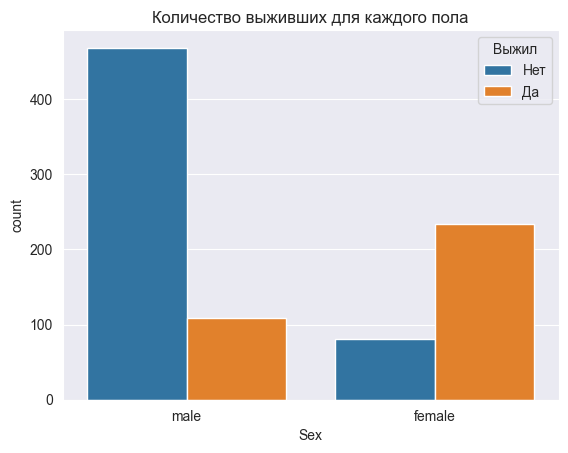

In [4]:
#Имел ли пол пассажира значение?
sns.countplot(data=train, x='Sex', hue='Survived')
plt.title('Количество выживших для каждого пола')
plt.legend(title="Выжил", labels=["Нет", "Да"])

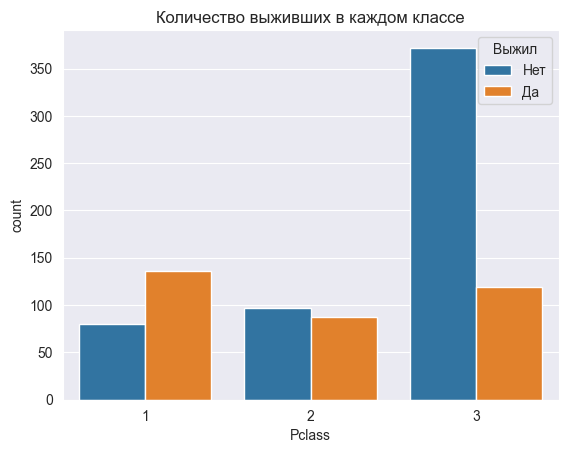

In [5]:
#Имел ли класс значение?
sns.countplot(data=train, x='Pclass', hue='Survived')
plt.title('Количество выживших в каждом классе')
plt.legend(title="Выжил", labels=["Нет", "Да"])

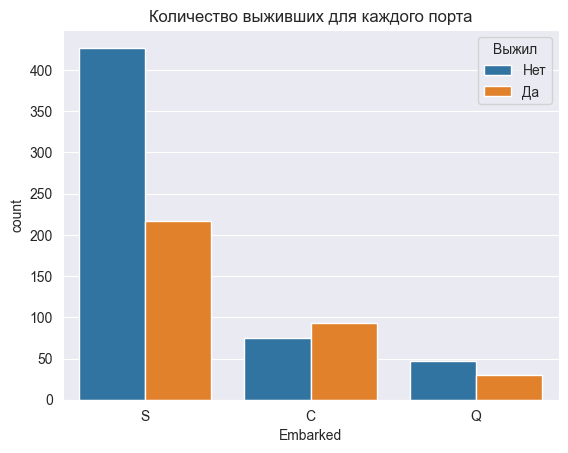

In [6]:
#Мог ли иметь значимость порт, в котором пассажира сели на корабль?
sns.countplot(data=train, x='Embarked', hue='Survived')
plt.title('Количество выживших для каждого порта')
plt.legend(title="Выжил", labels=["Нет", "Да"])

Видим меньшее количество выживших среди мужчин, так же,если для 1-го и 2-го класса количество выживших примерно одинаковое, для 3-го класса выживших меньше.
Наконец,видим что среди пассажиров из порта S соотношение не в пользу выживших, для других портов примерно одинаково.

Проверим так же, имело ли значение количество родственников на борту

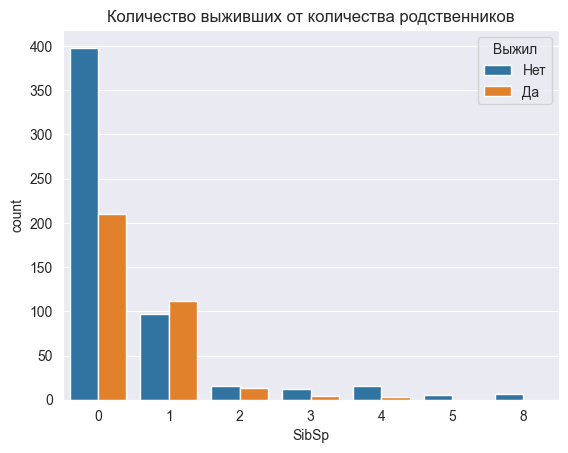

In [7]:
#Братья/сестры + мужья/жены, в графике назовем 'Родственники' чтобы как-то отличать от следующего графика
sns.countplot(data=train, x='SibSp', hue='Survived')
plt.title('Количество выживших от количества родственников')
plt.legend(title="Выжил", labels=["Нет", "Да"])

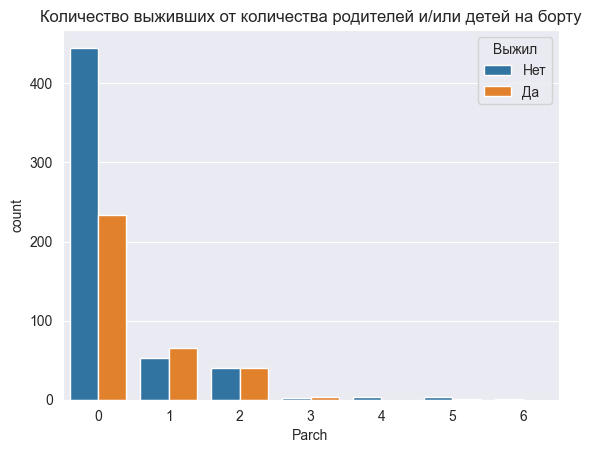

In [8]:
#Родители+Дети
sns.countplot(data=train, x='Parch', hue='Survived')
plt.title('Количество выживших от количества родителей и/или детей на борту')
plt.legend(title="Выжил", labels=["Нет", "Да"])

В основном можем видеть, что у людей отправившихся в одиночку было меньше шансов на выживание, при наличии хотя бы одного родственника распределение примерно одинаковое

Далее приступим к подготовке данных для обучения

In [9]:
# Посмотрим количество пустых значений
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

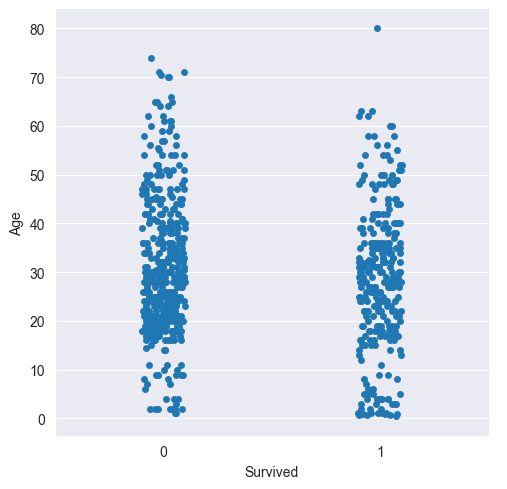

In [10]:
sns.catplot(data=train, x='Survived', y='Age')

Явно выделенного распределения не вижу, поэтому
пустые значения Age заполним средним.

В Embarked всего 2 пустых значения удалим из данных,

колонку Cabin, дропнем, т.к. она скорее пустая чем несет информацию.

In [11]:
train['Age'] = train['Age'].fillna(train['Age'].mean())

In [12]:
train['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [13]:
#61, 829
train[~train['Embarked'].isin(['S', 'C', 'Q'])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [14]:
train = train.drop([61, 829])

In [15]:
# Для колонок с родственниками и родителями оставим одну бинарную, если пассажир был один = 0,
# если вместе с ним был хоть один родственник = 1

train['is_alone'] = train['SibSp'] + train['Parch']
train['is_alone'] = train['is_alone'].apply(lambda x: 0 if x == 0 else 1)

In [16]:
train = train.drop(['Cabin','SibSp','Parch'], axis=1)

In [17]:
# Проверяем
train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
Ticket         0
Fare           0
Embarked       0
is_alone       0
dtype: int64

In [18]:
non_numeric_col = train.loc[:, train.dtypes == object].columns
train[non_numeric_col].head(10)

,Name,Sex,Ticket,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,S
4,"Allen, Mr. William Henry",male,373450,S
5,"Moran, Mr. James",male,330877,Q
6,"McCarthy, Mr. Timothy J",male,17463,S
7,"Palsson, Master. Gosta Leonard",male,349909,S
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,347742,S
9,"Nasser, Mrs. Nicholas (Adele Achem)",female,237736,C


Для не числовых колонок:
Name и Ticket дропнем,
Для колонки Sex поменяем значения на male=1, female=0,
В остальных применим One Hot Encoder

In [19]:
train = train.drop(['Name', 'Ticket'], axis=1)
train['Sex'] = train['Sex'].map({'male':1, 'female':0})

In [20]:
one_hot = pd.get_dummies(train['Embarked'], prefix='Embarked', drop_first=True)
train = pd.concat([train, one_hot], axis=1)
train = train.drop('Embarked', axis=1)

In [21]:
train.head(10)

,PassengerId,Survived,Pclass,Sex,Age,Fare,is_alone,Embarked_Q,Embarked_S
0,1,0,3,1,22.000000,7.2500,1,False,True
1,2,1,1,0,38.000000,71.2833,1,False,False
2,3,1,3,0,26.000000,7.9250,0,False,True
3,4,1,1,0,35.000000,53.1000,1,False,True
4,5,0,3,1,35.000000,8.0500,0,False,True
5,6,0,3,1,29.699118,8.4583,0,True,False
6,7,0,1,1,54.000000,51.8625,0,False,True
7,8,0,3,1,2.000000,21.0750,1,False,True
8,9,1,3,0,27.000000,11.1333,1,False,True
9,10,1,2,0,14.000000,30.0708,1,False,False


# Обучение модели и подбор параметров

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X = train.drop('Survived', axis=1)
y = train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('model', RandomForestClassifier())])

In [23]:
from sklearn.model_selection import GridSearchCV



param_grid = {'model__n_estimators': [100,200,500],
              'model__max_depth': [8,10,20],
              'model__random_state':[42]}

grid_search = GridSearchCV(pipe, param_grid,scoring='f1_weighted')
grid_search.fit(X_train, y_train)
print(grid_search.best_score_, grid_search.best_params_)


0.8280741214146998 {'model__max_depth': 8, 'model__n_estimators': 500, 'model__random_state': 42}


In [24]:
model = grid_search.best_estimator_

In [25]:
final_pipe = Pipeline([('scaler', StandardScaler()),
                       ('model', model)])

final_pipe.fit(X_train, y_train)

score = final_pipe.score(X_test, y_test)
print(score)

0.797752808988764


# Предсказание на тесте и подготовка CSV

In [26]:
test = pd.read_csv('../data/titanic/test.csv')

In [27]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [28]:
test['Age'] = test['Age'].fillna(test['Age'].mean())
test['Fare'] = test['Fare'].fillna(test['Fare'].mean())

In [29]:
test['Sex'] = test['Sex'].map({'male':1, 'female':0})

In [30]:
test['is_alone'] = test['SibSp'] + test['Parch']
test['is_alone'] = test['is_alone'].apply(lambda x: 0 if x == 0 else 1)

In [31]:
one_hot_test = pd.get_dummies(test['Embarked'], prefix='Embarked', drop_first=True)
test = pd.concat([test, one_hot_test], axis=1)

In [32]:
test = test.drop(['Name', 'Ticket', 'Cabin', 'Embarked', 'SibSp', 'Parch'], axis=1)

In [33]:
test.head()

,PassengerId,Pclass,Sex,Age,Fare,is_alone,Embarked_Q,Embarked_S
0,892,3,1,34.5,7.8292,0,True,False
1,893,3,0,47.0,7.0000,1,False,True
2,894,2,1,62.0,9.6875,0,True,False
3,895,3,1,27.0,8.6625,0,False,True
4,896,3,0,22.0,12.2875,1,False,True


In [34]:
submission = pd.DataFrame()
pred = final_pipe.predict(test)

submission['PassengerId'] = test['PassengerId']
submission['Survived'] = pred

In [35]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [36]:
submission.to_csv('submission.csv', index=False)